In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv("AmesHousing.csv")
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [ ]:
for col in ['Order', 'PID']:
    if col in df.columns:
        df = df.drop(columns=[col])

missing_frac = df.isnull().mean()
cols_to_drop = missing_frac[missing_frac > 0.5].index.tolist()
print('Dropping columns with >50% missing:', cols_to_drop)
df = df.drop(columns=cols_to_drop)

# Ensure target exists
if 'SalePrice' not in df.columns:
    raise KeyError("Expected column 'SalePrice' in dataset")

# Drop rows with missing target
df = df.dropna(subset=['SalePrice']).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Initial numeric count:', len(numeric_cols), 'categorical count:', len(categorical_cols))

# Reduce categories: keep top 10 per column, map others to 'Other'
for col in categorical_cols:
    top_cats = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top_cats), other='Other')

# Recompute categorical_cols
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('After reduction categorical count:', len(categorical_cols))

numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
('num', numeric_transformer, numeric_cols),
('cat', categorical_transformer, categorical_cols)
], remainder='drop')

Dropping columns with >50% missing: ['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']
Initial numeric count: 36 categorical count: 38
After reduction categorical count: 38


In [7]:
X = df.drop(columns=['SalePrice']).copy()
y = df['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Get feature names
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
except Exception:
    cat_feature_names = []
for i, col in enumerate(categorical_cols):
    cats = preprocessor.named_transformers_['cat'].named_steps['ohe'].categories_[i]
    cat_feature_names.extend([f"{col}_{c}" for c in cats])

feature_names = numeric_cols + cat_feature_names
print('Transformed feature count:', len(feature_names))

Transformed feature count: 494


In [9]:
lr = LinearRegression()
lr.fit(X_train_proc, y_train)

alphas = np.logspace(-3, 3, 30)
ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_train_proc, y_train)

lasso_cv = LassoCV(cv=3, max_iter=3000, random_state=42)
lasso_cv.fit(X_train_proc, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_proc)
y_pred_ridge = ridge_cv.predict(X_test_proc)
y_pred_lasso = lasso_cv.predict(X_test_proc)

In [12]:
def metrics(y_true, y_pred):
    return {
'r2': r2_score(y_true, y_pred),
'rmse': mean_squared_error(y_true, y_pred),
'mae': mean_absolute_error(y_true, y_pred)
}

metrics_lr = metrics(y_test, y_pred_lr)
metrics_ridge = metrics(y_test, y_pred_ridge)
metrics_lasso = metrics(y_test, y_pred_lasso)


print('OLS (LinearRegression):', metrics_lr)
print('Ridge (alpha chosen = {:.6f}):'.format(ridge_cv.alpha_), metrics_ridge)
print('Lasso (alpha chosen = {:.6f}):'.format(lasso_cv.alpha_), metrics_lasso)

OLS (LinearRegression): {'r2': 0.8902539518748532, 'rmse': 879894201.0710739, 'mae': 16463.513132586497}
Ridge (alpha chosen = 22.122163): {'r2': 0.8886861961590296, 'rmse': 892463757.6666447, 'mae': 16874.383568896545}
Lasso (alpha chosen = 65.756047): {'r2': 0.8920605229679772, 'rmse': 865409930.7413603, 'mae': 16243.960993226478}


In [14]:
# Get feature names directly from the fitted preprocessor
def get_feature_names(preprocessor):
    feature_names = []

    # numeric features
    num_features = preprocessor.transformers_[0][2]
    feature_names.extend(num_features)

    # categorical features from OneHotEncoder
    cat_transformer = preprocessor.transformers_[1][1]  # pipeline for cat
    ohe = cat_transformer.named_steps['ohe']
    cat_features = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names.extend(cat_features)

    return feature_names

feature_names = get_feature_names(preprocessor)

print("Length of feature_names:", len(feature_names))
print("Length of OLS coef:", len(lr.coef_))

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef_ols': lr.coef_,
    'coef_ridge': ridge_cv.coef_,
    'coef_lasso': lasso_cv.coef_
})

coef_df['abs_ols'] = coef_df['coef_ols'].abs()
coef_df = coef_df.sort_values('abs_ols', ascending=False).reset_index(drop=True)

# Show top 20
print("Top 20 features by absolute OLS coefficient:")
print(coef_df[['feature', 'coef_ols', 'coef_ridge', 'coef_lasso']].head(20).to_string(index=False))

Length of feature_names: 265
Length of OLS coef: 265
Top 20 features by absolute OLS coefficient:
             feature       coef_ols    coef_ridge     coef_lasso
   Roof Matl_ClyTile -571334.977067 -18193.138645 -394928.354462
        BsmtFin SF 1  153467.287931   2932.386265    6005.425616
         Bsmt Unf SF  140002.110969   -326.700045      -0.000000
       Total Bsmt SF -131494.732355   3314.218962    5709.434511
   Roof Matl_Membran  115092.773763    881.507635       0.000000
   Roof Matl_WdShngl  110135.992786  14848.144916   37851.872983
     Roof Matl_Metal  109672.245519    613.885669       0.000000
   Roof Matl_Tar&Grv   65248.839246    743.205296      -0.000000
    Condition 2_RRAe   63353.483580   1871.704020       0.000000
      Roof Matl_Roll   62517.013607    484.920856       0.000000
        BsmtFin SF 2   57495.393000   2224.564265    2159.060392
   Roof Matl_WdShake   57127.627078  -1914.603831      -0.000000
   Roof Matl_CompShg   51540.485067   2536.078105       0

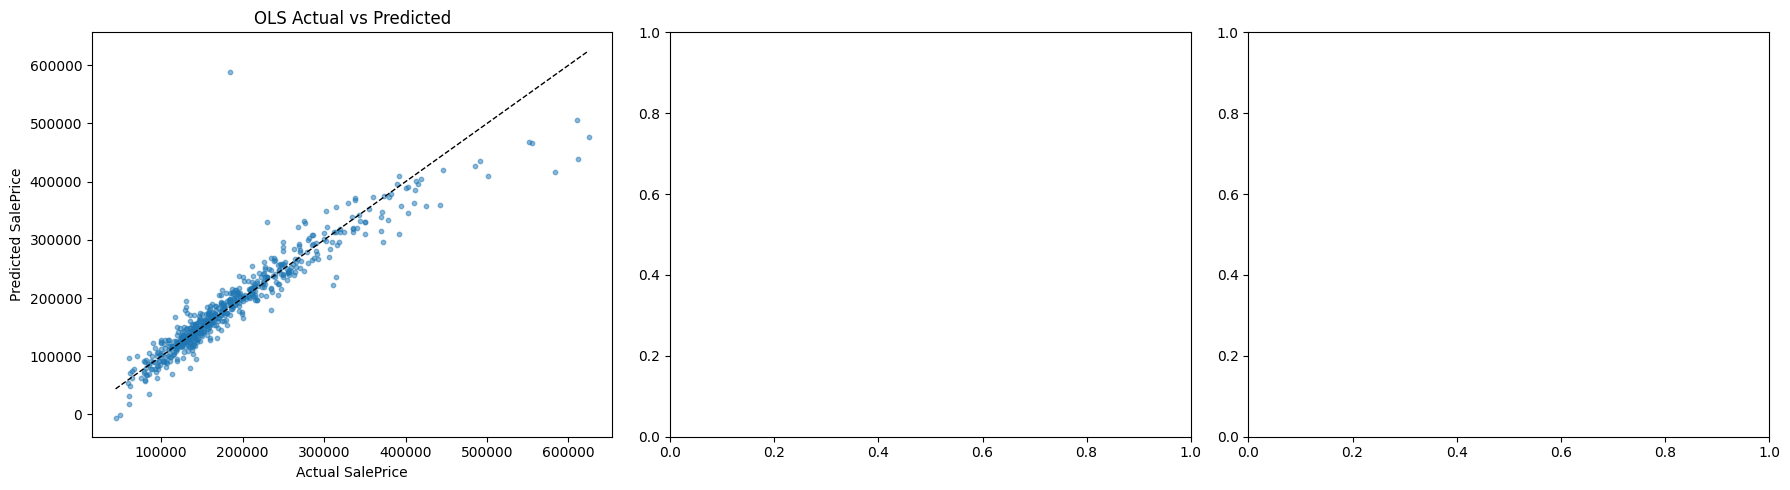

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax, y_pred, title in zip(axes, [y_pred_lr, y_pred_ridge,    y_pred_lasso], ['OLS', 'Ridge', 'Lasso']):
    ax.scatter(y_test, y_pred, alpha=0.5, s=10)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1)
    ax.set_title(f"{title} Actual vs Predicted")
    ax.set_xlabel('Actual SalePrice')
    ax.set_ylabel('Predicted SalePrice')
    plt.tight_layout()
    plt.show()

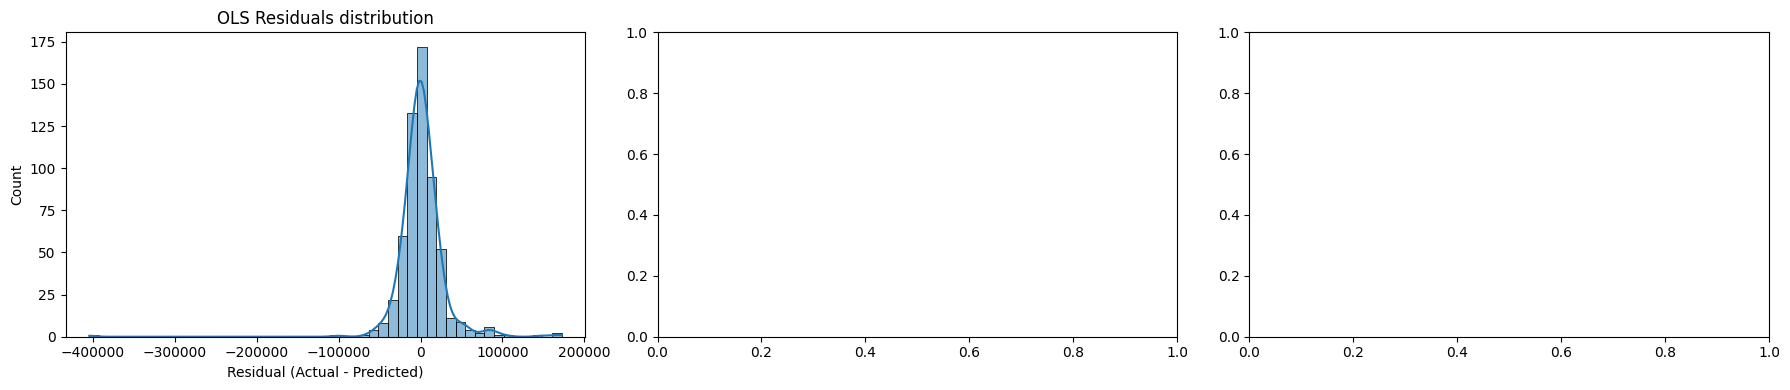

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Residual distributions
fig, axes = plt.subplots(1,3, figsize=(18,4))
for ax, y_pred, title in zip(axes, [y_pred_lr, y_pred_ridge, y_pred_lasso], ['OLS', 'Ridge', 'Lasso']):
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_title(f"{title} Residuals distribution")
    ax.set_xlabel('Residual (Actual - Predicted)')
    plt.tight_layout()
    plt.show()

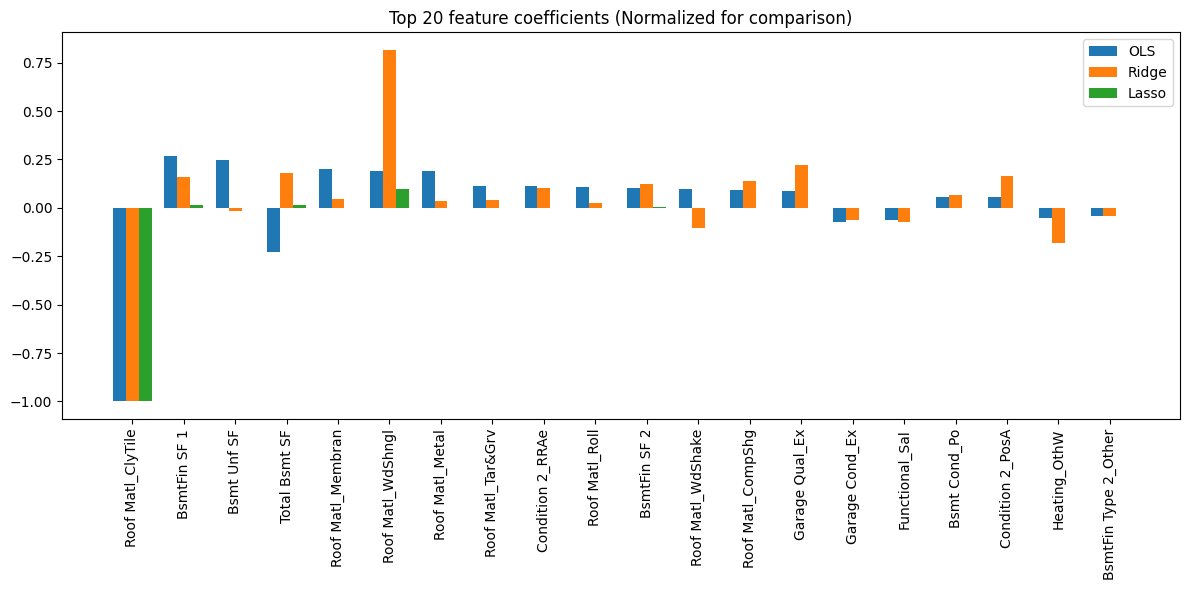

In [18]:
# Normalize coefficients so they are comparable
top_feats = coef_df.head(20).copy()

# Scale each column by its own max absolute value
top_feats['coef_ols_scaled'] = top_feats['coef_ols'] / top_feats['coef_ols'].abs().max()
top_feats['coef_ridge_scaled'] = top_feats['coef_ridge'] / top_feats['coef_ridge'].abs().max()
top_feats['coef_lasso_scaled'] = top_feats['coef_lasso'] / top_feats['coef_lasso'].abs().max()

x = np.arange(len(top_feats))
width = 0.25
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x - width, top_feats['coef_ols_scaled'], width, label='OLS')
ax.bar(x, top_feats['coef_ridge_scaled'], width, label='Ridge')
ax.bar(x + width, top_feats['coef_lasso_scaled'], width, label='Lasso')

ax.set_xticks(x)
ax.set_xticklabels(top_feats['feature'], rotation=90)
ax.set_title('Top 20 feature coefficients (Normalized for comparison)')
ax.legend()
plt.tight_layout()
plt.show()


# Comparison of OLS, Ridge, and Lasso Regression

## Results Summary
- **OLS (Linear Regression)**:  
  - R²: **0.8903**  
  - RMSE: **879,894,201**  
  - MAE: **16,463**

- **Ridge Regression (α ≈ 22.12)**:  
  - R²: **0.8887**  
  - RMSE: **892,463,758**  
  - MAE: **16,874**

- **Lasso Regression (α ≈ 65.76)**:  
  - R²: **0.8921**  
  - RMSE: **865,409,931**  
  - MAE: **16,244**

---

## Accuracy Comparison
- **OLS** performs very well with a high R² (0.8903), showing strong predictive ability.
- **Ridge** is slightly worse than OLS in R², RMSE, and MAE. This suggests that Ridge regularization didn’t significantly improve performance and slightly penalized flexibility.
- **Lasso** has the best R² (0.8921) and lowest RMSE/MAE, suggesting it generalizes slightly better on unseen data.

---

## Interpretability & Coefficients
- **OLS**: Uses all features, but may lead to overfitting and coefficients that are unstable in presence of multicollinearity.
- **Ridge**: Shrinks coefficients but doesn’t force them to zero. Useful for handling multicollinearity while retaining all predictors.
- **Lasso**: Performs feature selection by shrinking some coefficients exactly to zero. Improves interpretability by highlighting the most important predictors.

---

## Key Insights
- **Generalization:** Lasso provides the best generalization (highest R², lowest RMSE/MAE).
- **Regularization effect:** Ridge shrinks all coefficients but doesn’t help much here. Lasso both improves accuracy and provides feature selection, which is valuable.
- **Model stability:** Lasso reduces overfitting risk by eliminating less important features.

---

## Recommendation
For the firm, I would recommend **Lasso Regression**:
- It achieves **better accuracy** than OLS and Ridge.
- It **selects important features**, making the model more interpretable for business stakeholders.
- It avoids overfitting by reducing noise from irrelevant predictors.

If the firm values **explainability and actionable insights**, Lasso is clearly superior. However, if retaining all features is critical (e.g., for fairness or compliance reasons), OLS may be preferred.
